# Cross-correlation (8 marks, 4/4)

It has been shown that noise records at two seismic stations, when cross-correlated and stacked,
are very closely associated with the Green's function between these two seismic stations (i.e. given
a delta force at one station, the displacement recorded at the other station). On Quercus,
two files are given: one is a vertical component seismogram at PHL (Park Hill) and the other is
a vertical component seismogram at MLAC (Mammoth Lakes). Both are records for one day (24
hours) on February 1, 2003. Sampling rate is $dt = 1.0$ seconds.

 1. Take the cross-correlation (using FFT) of these seismograms using the record at PHL as $x(t)$
    and that at MLAC as $y(t)$ and plot $C_{xy}(\tau)$. Zoom in your plot between [-250; 250] seconds.
 2. Bit conversion is often used for the cross-correlation Greens function approach. It simply
    changes any positive numbers to 1 and negative numbers to -1 (numpy `sign()` function).
    Apply this to the data at PHL and MLAC and compute their cross-correlation. Compare
    the results against those from the previous step. Does bit-conversion work in this case to
    preserve the phase information of the true cross-correlation? (Note the amplitude of
    bit-converted cross-correlation is of no meaning).

    _Hint_: for discrete cross-correlation using fft:
    - suppose `x = [x0 x1 ... x(N-1)]; y = [y0 y1 ... y(N-1)]`
    - note conv(x,y)=v=[v0 v1 ... v(2N-2)], and notice the relationship between convolution and cross-correlation
    - also note how the fourier transform of the cross-correlation is related to $X(w)^*Y(w)$
    - if we first pad the end of each x and y array with N-1 zeros, convolution theorem suggests that we can interpret the inverse transform of $X^*(w)Y(w)$ as the result of a convolution (length 2N-1), w, interpreted as:  
          w = ifft(...)
            = [w[lag = 0] w[lag = 1 dt] ... w[lag = (N-1) dt] w[lag = -(N-1) dt] ... w[lag = -1 dt]]
    - we then must apply fftshift to center the time shift/lag axis at 0
    - the point of this fft approach is that it's much faster than directly convolving; you can check against  np.correlate(x, y, mode='same')
    - "zoom your plot to [-250, 250]" is in reference to the time lag axis in the above process

    _Hint_: you can load the ascii file into Python by `genfromtxt` function:  
        tmp = np.genfromtxt('MLAC_data.txt')  
        mlac = tmp.flatten()

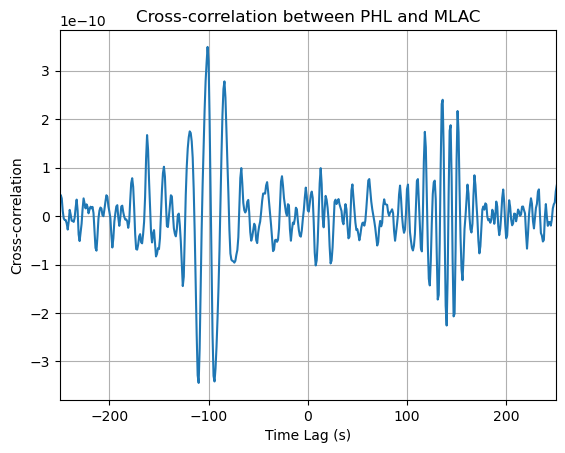

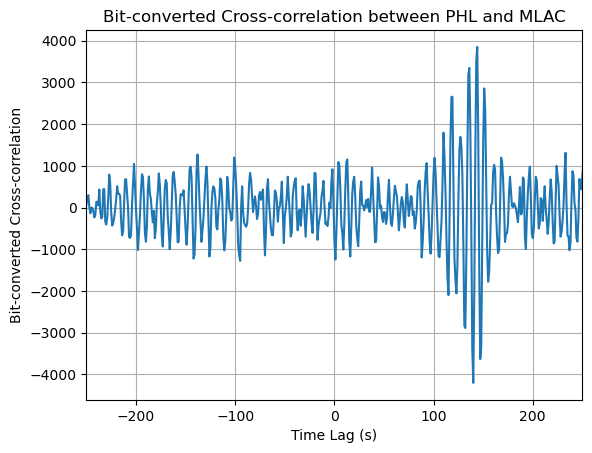

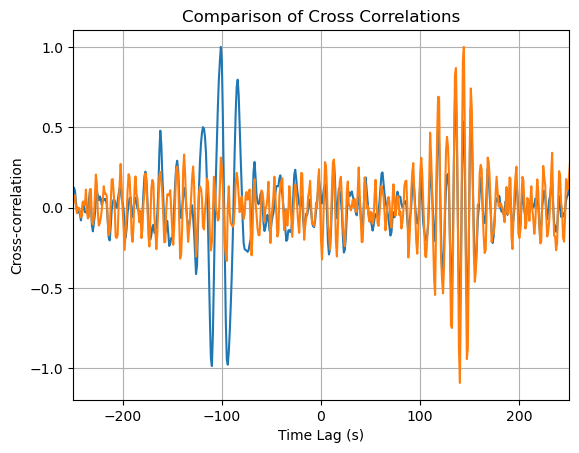

In [4]:
# Collaborated with Abramo Ginevra

import numpy as np
import matplotlib.pyplot as plt

# Getting data from the files
mlac = np.genfromtxt('MLAC_data.txt').flatten()
phl = np.genfromtxt('PHL_data.txt').flatten()
dt = 1 # sampling rate in seconds

## QUESTION 1

# Pad arrays with zeros to ensure same length
N = len(phl)
phl_padded = np.pad(phl, (0, N - 1), mode='constant')
mlac_padded = np.pad(mlac, (0, N - 1), mode='constant')

# Compute FFT of padded arrays
phl_fft = np.fft.fft(phl_padded)
mlac_fft = np.fft.fft(mlac_padded)

# Compute cross-correlation
correl_fft = np.fft.ifft(phl_fft.conj() * mlac_fft).real

# Shift and plot cross-correlation
x_axis = np.arange(-N + 1, N)
correl_fft_shifted = np.fft.fftshift(correl_fft)
plt.plot(x_axis, correl_fft_shifted)

# Zoom in the plot
plt.xlim(-250, 250)
plt.xlabel('Time Lag (s)')
plt.ylabel('Cross-correlation')
plt.title('Cross-correlation between PHL and MLAC')
plt.grid(True)
plt.show()
plt.figure()

## QUESTION 2

# Apply bit conversion to PHL and MLAC data
phl_bit = np.sign(phl)
mlac_bit = np.sign(mlac)

# Pad bit-converted arrays with zeros
phl_bit_padded = np.pad(phl_bit, (0, N - 1), mode='constant')
mlac_bit_padded = np.pad(mlac_bit, (0, N - 1), mode='constant')

# Compute FFT of bit-converted padded arrays
phl_bit_fft = np.fft.fft(phl_bit_padded)
mlac_bit_fft = np.fft.fft(mlac_bit_padded)

# Compute cross-correlation of bit-converted data
correl_bit_fft = np.fft.ifft(phl_bit_fft.conj() * mlac_bit_fft).real

# Shift and plot bit-converted cross-correlation
correl_bit_shifted = np.fft.fftshift(correl_bit_fft)
plt.plot(x_axis, correl_bit_shifted)

# Zoom in the plot
plt.xlim(-250, 250)
plt.grid(True)
plt.xlabel('Time Lag (s)')
plt.ylabel('Bit-converted Cross-correlation')
plt.title('Bit-converted Cross-correlation between PHL and MLAC')
plt.figure()

normalized = correl_fft_shifted/np.max(correl_fft_shifted)
normalized_bit = correl_bit_shifted/np.max(correl_bit_shifted)

plt.grid()
plt.xlabel('Time Lag (s)')
plt.ylabel('Cross-correlation')
plt.title('Comparison of Cross Correlations')
plt.xlim(-250, 250)
plt.plot(x_axis, normalized)
plt.plot(x_axis, normalized_bit)

# Normal Modes from Long Period Seismometer (7 marks, 1/2/2/1/1)

Background: The solid earth 'rings' like a bell after being struck by a great earthquake. These
are the normal modes associated with internal structures (density and elastic moduli) of the Earth,
and the excitation amplitudes of these modes are determined by the earthquake source mechanism.
The frequencies of these normal modes of oscillation are very low, usually between 0.1 milliHertz
(mHz) and 10 mHz. It is hard to see them above 10 mHz because these higher frequency modes
attenuate quickly, or the frequency spacings are too small to be identified individually. Because
the Earth is a complex structure, with twisting, breathing, and more complex spatial structure in
its modes, the modal frequencies are not simple multiples of a single fundamental as is the case
for a guitar string. They are labelled with a notation (e.g. like $_0S_2$ for spheroidal modes or like
$_1T_8$ for toroidal modes) based on the spherical harmonic spatial distribution that the mode corresponds
to, in the same way that the electron wavefunctions for the Hydrogen atom are labelled. Geophysicists
measure these frequencies because they can be used to invert for models of the Earth's
internal seismic velocity and density structures. With very high-resolution data, one can even see
splitting of these resonances due to the Earth’s rotation and elliptical shape, in a matter analogous
to the Zeeman splitting of atomic spectral lines. You can also optically detect similar phenomenon
('helioseismology') going on in the sun, from which one can also test models of the sun's interior.
(More descriptions can be found on any introductory solid-earth geophysics book).
Here we examine three days of very long period seismic data recorded on the horizontal direction at
station NWAO (Narrogin, Western Australia) after the devastating $M_w = 9.0$, Mar 11th, 2011 Honshu,
Japan earthquake. Data `nwao.vh1` (VH channel, $dt = 10 \text{ sec}$) is given as an ascii
file with two columns: time and velocity (in counts from the digitizer).

 1. Plot the raw data with a time axis in hours.
 2. Plot the power spectrum of your raw data as a function of frequency (in mHz) **without**
    any windowing.
 3. Plot the power spectrum of your raw data after 
     - removing the minor linear trend in the same way as Lab 3, and subsequently 
     - applying a hanning window $w_n = 1 - \cos(2 \pi \frac{n}{N}) ; 0 \leq n \leq N$ (where N is the length of the data file)
 4. Plot on top of each other the power spectra from 2 and 3 between [0.1, 2.6] mHz, and comment on the difference.
 5. Using plt.annotate(...), identify any normal modes you can see. Use the provided modes.pdf (Table 1) to help guide your identification.

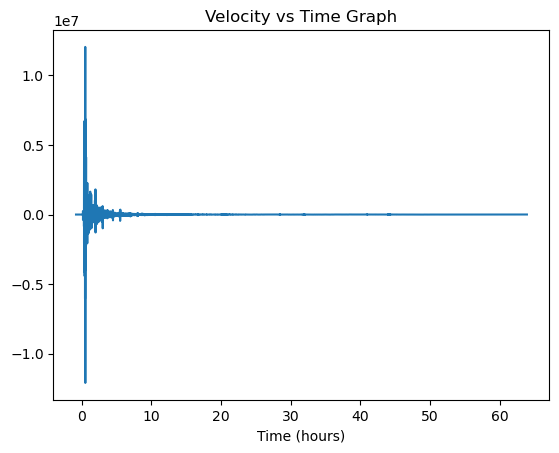

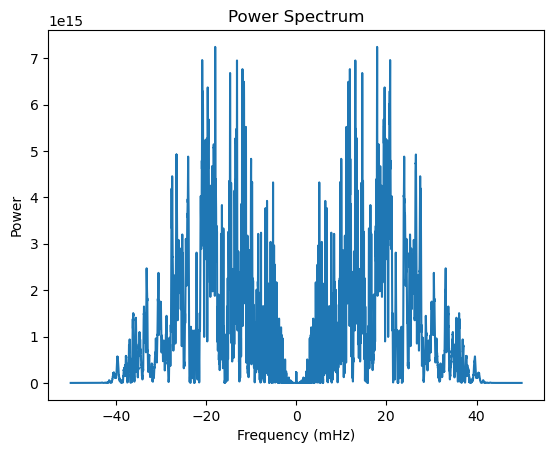

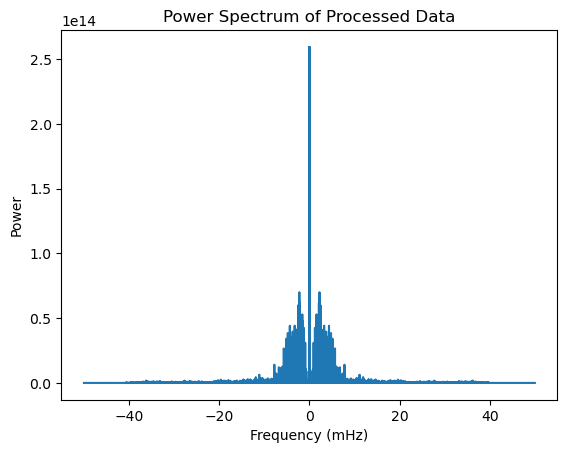

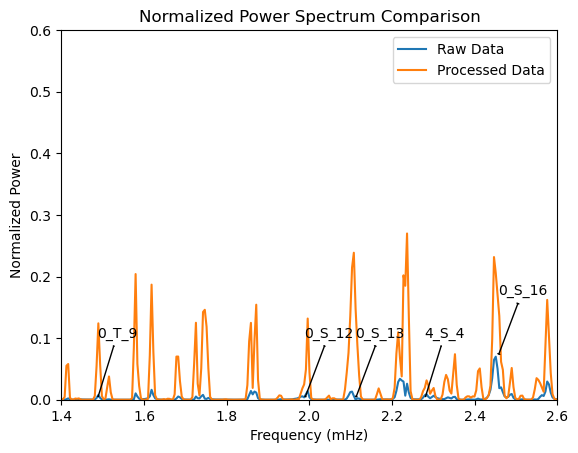

In [31]:
# Collaborated with Abramo Ginevra

## PART 1

# Loading data from file
time, vel = np.loadtxt("nwao.vh1", delimiter=' ', unpack=True)
hours = [t/3600 for t in time]
dt = 10 #sec

N = len(hours)

# Plotting raw data w/ time axis in hours
plt.title("Velocity vs Time Graph")
plt.xlabel("Time (hours)")
plt.plot(hours, vel)
plt.figure()

## PART 2: Plotting the Power Spectrum

# Computing the Power Spectrum
fft = np.fft.fft(vel)
fft_shifted = np.fft.fftshift(fft)  # Shift the FFT result
f_axis = np.fft.fftfreq(len(fft), dt)
f_axis_shifted = np.fft.fftshift(f_axis)  # Shift the frequency axis
millihertz = f_axis_shifted * 1000  # Convert to millihertz

power_spec = np.abs(fft_shifted) ** 2
plt.title("Power Spectrum")
plt.xlabel("Frequency (mHz)")
plt.ylabel("Power")
plt.plot(millihertz, power_spec)
plt.figure()


## PART 3: Plotting the Power Spectrum after Processing

# Removing the linear trend
coefficients = np.polyfit(time, vel, 1)
detrended = vel - (coefficients[0] * time + coefficients[1])

# Applying the Hann Window
hann = 1 - np.cos(2 * np.pi * (np.arange(N)/N))
detrended_windowed = detrended * hann

# Computing the Power Spectrum of the Processed Data
fft_processed = np.fft.fft(detrended_windowed)
fft_processed_shifted = np.fft.fftshift(fft_processed)  # Shift the FFT result
power_spec_processed = np.abs(fft_processed_shifted) ** 2

plt.title("Power Spectrum of Processed Data")
plt.xlabel("Frequency (mHz)")
plt.ylabel("Power")
plt.plot(millihertz, power_spec_processed)
plt.figure()

## PART 4: COMPARING POWER SPECTRA

# Normalize the power spectra
normalized_power_spec = power_spec / np.max(power_spec)
normalized_power_spec_processed = power_spec_processed / np.max(power_spec_processed)

# Plotting the normalized Power Spectra from Parts 2 and 3
plt.plot(millihertz, normalized_power_spec, label='Raw Data')
plt.plot(millihertz, normalized_power_spec_processed, label='Processed Data')
plt.title("Normalized Power Spectrum Comparison")
plt.xlabel("Frequency (mHz)")
plt.ylabel("Normalized Power")
plt.xlim(0.1, 2.6)
plt.ylim(0, 0.2)
plt.legend()


## PART 5: NORMAL MODES

# The normal modes are the frequencies where the peaks of the Fourier transforms align.
# For simplicity we will annotate only 5 of them

modes = [(2.279, 0.001), (1.487, 0.001), (1.988, 0.001), (2.111, 0.001), (2.456, 0.07)]  # Coordinates of modes (x, y)
mode_labels = ["4_S_4", "0_T_9", "0_S_12", "0_S_13", "0_S_16"]

# Adjusting the annotation positions and arrow heights for all modes using a loop with index i
for i in range(len(modes)):
    mode = modes[i]
    label = mode_labels[i]
    arrow_height = 0.1 * (i + 1)  # Increase arrow height for each mode
    plt.annotate(label, mode, xytext=(mode[0] , mode[1] + 0.1),
                 arrowprops=dict(arrowstyle='|-|,widthA=0.1,widthB=0.1',
                                 lw=1, mutation_scale=15 * arrow_height))

# Adjust plot limits to ensure all annotations are visible
plt.xlim(1.4, 2.6)
plt.ylim(0, 0.6)

plt.show()
